In [1]:
import os
import sys
import pickle
from tqdm.notebook import tqdm as tqdm
import random

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

sys.path.append("../")

from batch_generators import BinaryDataGenerator
from models import BinaryRankingModel
from tools import test_quality
from clr import cyclic_learning_rate

In [2]:
s = 2

random.seed(s)
np.random.seed(s)
tf.set_random_seed(s)
os.environ['PYTHONHASHSEED'] = str(s)
os.environ['TF_CUDNN_DETERMINISTIC'] = str(s)

##### Load METABRIC data

In [3]:
with open('../data/metabric_cv.pkl', 'rb') as f:
    df_all = pickle.load(f)

In [4]:
df_all.keys()

dict_keys(['val', 'cv'])

In [5]:
df_all['cv'].keys()

dict_keys([0, 1, 2, 3, 4])

Set common parameters for learning

In [6]:
folds = list(df_all['cv'].keys())

Define parameters grid

In [7]:
n_time_bins = 10
time_grid = np.linspace(0, 300, 30, dtype=np.int)
inp_shape = (None, df_all['val']['x'].shape[1])
n_epochs = 30

static_params = {
    'n_time_bins': n_time_bins,
    'inp_shape': inp_shape,
    'n_epochs': n_epochs,
    'seed': s,
    'max_lr': 0.002,
    'step_size': 13,
    'time_grid': time_grid   
}

In [8]:
# 48 combinations
batch_size = [1024, 2048]
alpha_reg = [1e-4, 1e-5, 1e-6]
cross_entropy_weight = [1, 3, 5, 7]

param_grid = {
    'batch_size': batch_size, 
    'alpha_reg': alpha_reg,
    'cross_entropy_weight': cross_entropy_weight
}
grid = ParameterGrid(param_grid)

Define testing function

In [9]:
def test_hp(train_data, test_data, model_params):
        
    model = BinaryRankingModel(model_params['inp_shape'], seed=model_params['seed'], alpha_reg=model_params['alpha_reg'], 
                           cross_entropy_weight=model_params['cross_entropy_weight'])
    
    # cycling learning rate
    all_lr = []
    global_step = tf.Variable(0, trainable=False)
    increment_global_step = tf.assign(global_step, global_step + 1)
    learning_rate = cyclic_learning_rate(global_step=global_step, learning_rate=model_params['max_lr'] / 5, max_lr=model_params['max_lr'], 
                                         step_size=model_params['step_size'], mode='triangular2')
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    
    train = optimizer.minimize(model.loss, global_step=global_step)
    
    # validation data
    dg = BinaryDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], batch_size=model_params['batch_size'], n_time_bins=model_params['n_time_bins'])
    val_size = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1])
    dg = BinaryDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], batch_size=val_size, n_time_bins=model_params['n_time_bins'])
    [x_batch_left_val, x_batch_right_val], y_batch_val, sample_weight_val, target_val = next(dg.get_batch())
    val_size = x_batch_left_val.shape[0]
    # training data
    dg = BinaryDataGenerator(x=train_data['x'], y=train_data['y'], t=train_data['t'], batch_size=model_params['batch_size'],
                             n_time_bins=model_params['n_time_bins'])    
    n_batches = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1]) // model_params['batch_size']
    
    all_lr = []
    all_pred = []
    train_loss = []
    val_loss = []
    # Launch the graph
    with tf.device('/GPU:0'):
        with tf.Session() as sess:
            tf.set_random_seed(model_params['seed'])
            init = tf.initialize_all_variables()
            sess.run(init)
            # for each epoch
            for i in tqdm(range(model_params['n_epochs'])):
                # initialize generator
                gen = dg.get_batch()
                # for each batch
                for j in range(n_batches):
                    # get batch data
                    [x_batch_left, x_batch_right], y_batch, sample_weight, target = next(gen)
                    feed_dict = {
                        model.x_a: x_batch_left, 
                        model.x_b: x_batch_right, 
                        model.t_a: y_batch[:, 0].reshape((model_params['batch_size'], 1)),
                        model.t_b: y_batch[:, 1].reshape((model_params['batch_size'], 1)),
                        model.y_a: y_batch[:, 2].reshape((model_params['batch_size'], 1)),
                        model.y_b: y_batch[:, 3].reshape((model_params['batch_size'], 1)),
                        model.target: target.reshape((model_params['batch_size'], 1)),
                        model.sample_weight: sample_weight
                    }                   
                    # train model
                    _, l = sess.run([train, model.loss], feed_dict=feed_dict)
                    
                 # change learning rate
                assign_op = global_step.assign(i)
                sess.run(assign_op)               
                new_lr = sess.run(optimizer._learning_rate_tensor)
                all_lr.append(new_lr)
              
                # get predictions for validation data
                pred = sess.run(model.o1, feed_dict={model.x_a: test_data['x']})
                all_pred.append(pred)
                # save train loss
                train_loss.append(l)
                # save test loss
                l = sess.run(model.loss, feed_dict={
                        model.x_a: x_batch_left_val, 
                        model.x_b: x_batch_right_val, 
                        model.t_a: y_batch_val[:, 0].reshape((val_size, 1)),
                        model.t_b: y_batch_val[:, 1].reshape((val_size, 1)),
                        model.y_a: y_batch_val[:, 2].reshape((val_size, 1)),
                        model.y_b: y_batch_val[:, 3].reshape((val_size, 1)),
                        model.target: target_val.reshape((val_size, 1)),
                        model.sample_weight: sample_weight_val
                    }) 
                val_loss.append(l)
                
    return pred, train_loss, val_loss, all_lr


Grid search

In [10]:
all_res_quality = []
test_data = df_all['val']
for fold in tqdm(folds):
    train_data = df_all['cv'][fold]['train']
    for params in tqdm(grid):
        tf.reset_default_graph()
        params.update(static_params)
        pred, train_loss, val_loss, all_lr = test_hp(train_data=train_data, test_data=test_data, model_params=params)
        q = test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred, time_grid=params['time_grid'], concordance_at_t=103)
        q['batch_size'] = params['batch_size']
        q['alpha_reg'] = params['alpha_reg']
        q['cross_entropy_weight'] = params['cross_entropy_weight']
        q['fold'] = fold
        q['train_loss'] = [train_loss]
        q['val_loss'] = [val_loss]
        q['learning_rate'] = [all_lr]
        all_res_quality.append(q)
       
        with open('../output/hp_search_w_ce_v4.pkl', 'wb') as f:
            pickle.dump(all_res_quality, f)





Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.dense instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.global_variables_initializer` instead.


Select best hyperparameters on validation data

In [15]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("viridis")

In [28]:
with open('../output/hp_search_w_ce_v4.pkl', 'rb') as f:
    data = pickle.load(f)

In [29]:
data = pd.concat(data)

In [30]:
data

,harell_c_index,dt_c_index,int_brier_score,int_nbill,batch_size,alpha_reg,cross_entropy_weight,fold,train_loss,val_loss,learning_rate
0,0.658042,0.661861,0.162428,0.482588,1024,0.000100,1,0,"[5.82977, 4.6863756, 4.061999, 3.9432023, 3.77...","[5.6416774, 4.5120287, 4.050278, 3.8653035, 3....","[0.0004, 0.000523077, 0.0006461538, 0.00076923..."
0,0.659462,0.667600,0.161056,0.481604,1024,0.000100,3,0,"[7.8395367, 6.64004, 5.9334583, 5.8724737, 5.7...","[7.6377177, 6.436601, 5.9409046, 5.8046923, 5....","[0.0004, 0.000523077, 0.0006461538, 0.00076923..."
0,0.658322,0.668799,0.162210,0.486683,1024,0.000100,5,0,"[9.813709, 8.517286, 7.76416, 7.7232513, 7.609...","[9.60177, 8.264891, 7.780876, 7.657004, 7.5916...","[0.0004, 0.000523077, 0.0006461538, 0.00076923..."
0,0.647525,0.631688,0.176491,0.527159,1024,0.000100,7,0,"[11.756186, 10.33506, 9.560272, 9.5291195, 9.3...","[11.530127, 10.041924, 9.582647, 9.452349, 9.3...","[0.0004, 0.000523077, 0.0006461538, 0.00076923..."
0,0.652383,0.657962,0.164891,0.489113,2048,0.000100,1,0,"[7.467886, 5.4220557, 4.6863337, 4.361153, 4.1...","[7.1831284, 5.254601, 4.65802, 4.328313, 4.068...","[0.0004, 0.000523077, 0.0006461538, 0.00076923..."
...,...,...,...,...,...,...,...,...,...,...,...
0,0.646985,0.631169,0.175503,0.523281,1024,0.000001,7,4,"[11.838769, 10.316229, 9.62874, 9.537274, 9.44...","[11.8477955, 10.137548, 9.610268, 9.458809, 9....","[0.0004, 0.000523077, 0.0006461538, 0.00076923..."
0,0.646485,0.653223,0.166189,0.491818,2048,0.000001,1,4,"[7.552376, 5.7182994, 4.827098, 4.3410025, 4.0...","[7.4223833, 5.536351, 4.7222743, 4.2353625, 4....","[0.0004, 0.000523077, 0.0006461538, 0.00076923..."
0,0.646545,0.653663,0.166542,0.494950,2048,0.000001,3,4,"[9.528349, 7.666276, 6.719881, 6.2360215, 5.95...","[9.431383, 7.516781, 6.679539, 6.147253, 5.980...","[0.0004, 0.000523077, 0.0006461538, 0.00076923..."
0,0.642946,0.644925,0.170602,0.510986,2048,0.000001,5,4,"[11.488261, 9.589375, 8.579312, 8.079606, 7.77...","[11.425732, 9.468893, 8.590913, 8.002389, 7.82...","[0.0004, 0.000523077, 0.0006461538, 0.00076923..."


In [170]:
data['mean_3_train_loss'] = data['train_loss'].apply(lambda x: np.mean(np.array(x[-3:])))
data['mean_5_train_loss'] = data['train_loss'].apply(lambda x: np.mean(np.array(x[-5:])))
data['mean_3_val_loss'] = data['val_loss'].apply(lambda x: np.mean(np.array(x[-3:])))
data['mean_5_val_loss'] = data['val_loss'].apply(lambda x: np.mean(np.array(x[-5:])))

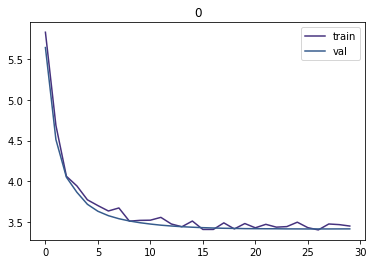

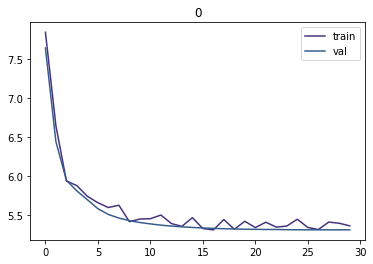

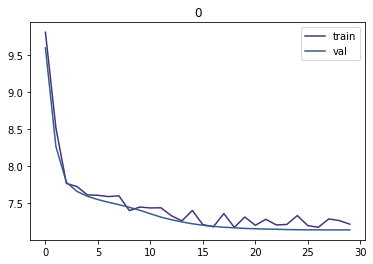

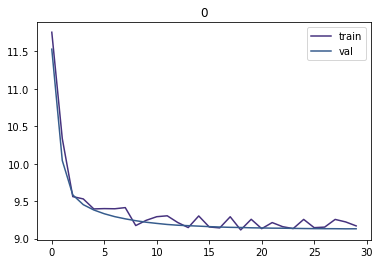

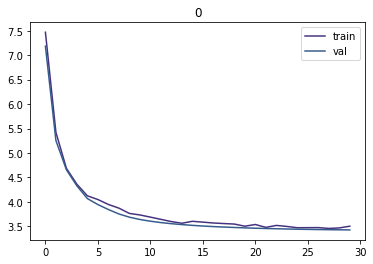

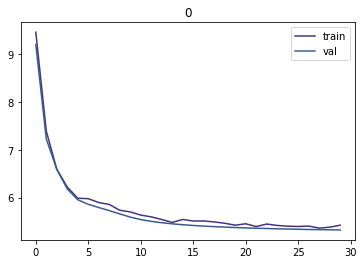

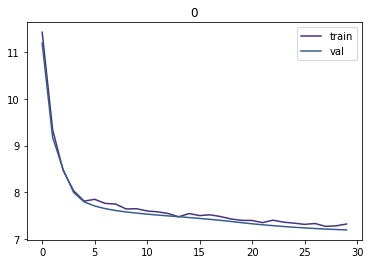

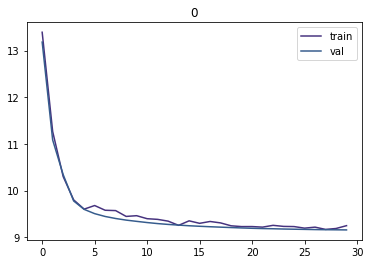

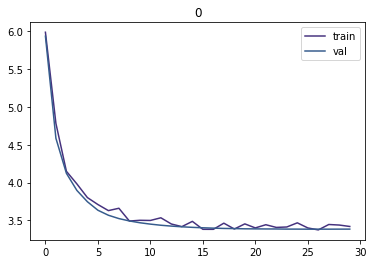

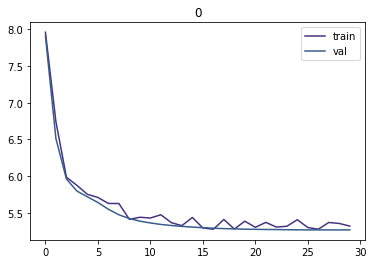

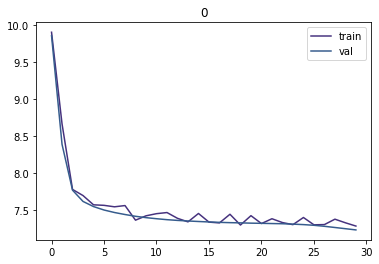

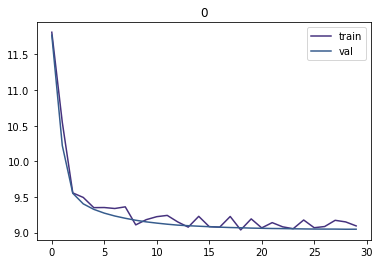

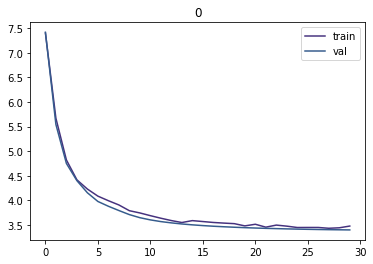

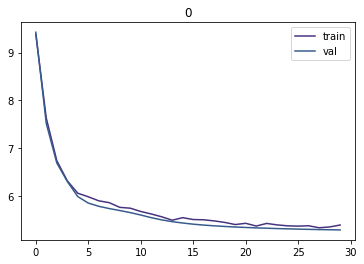

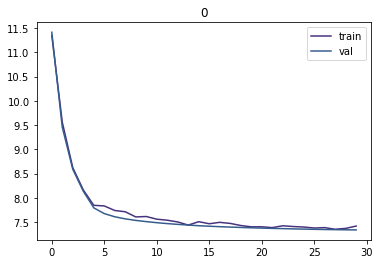

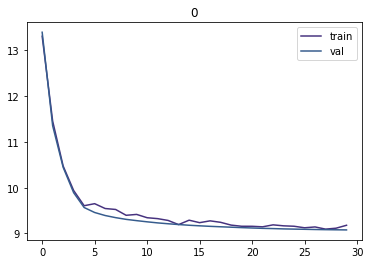

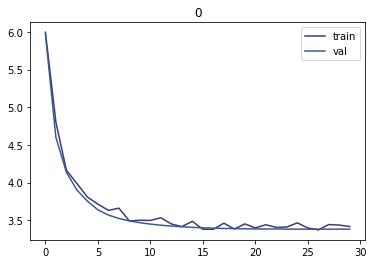

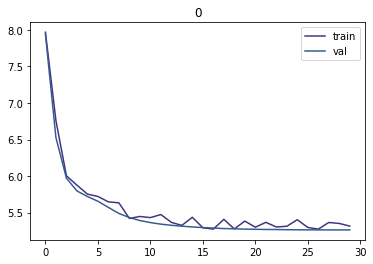

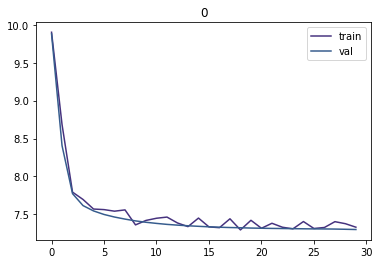

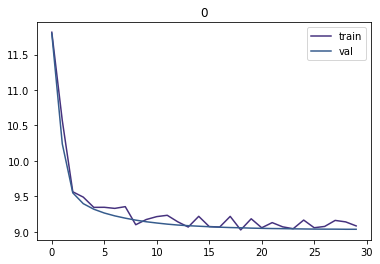

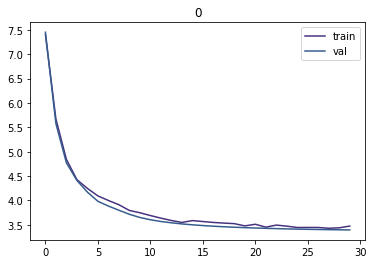

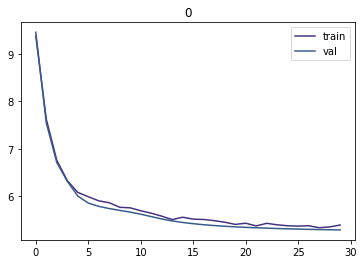

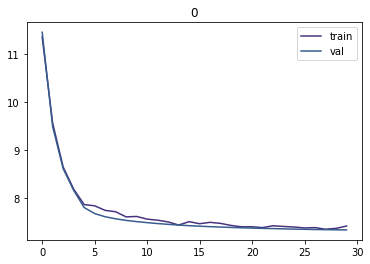

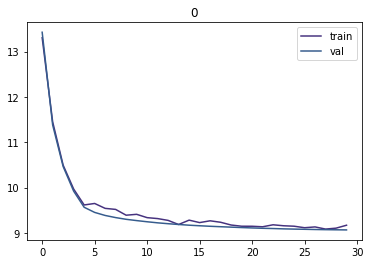

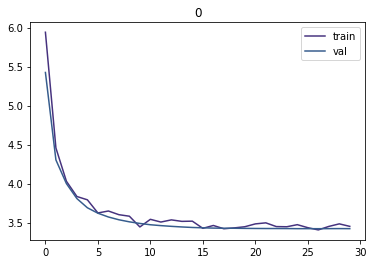

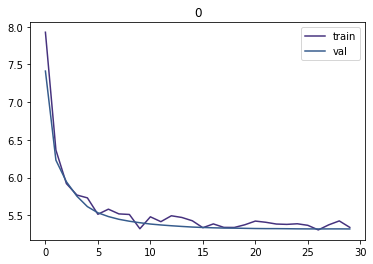

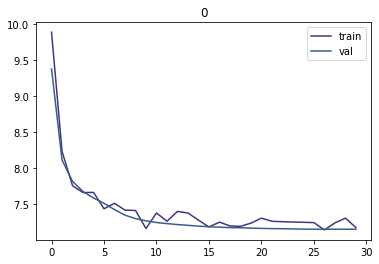

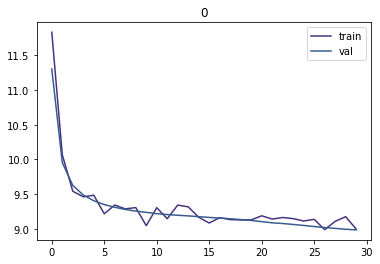

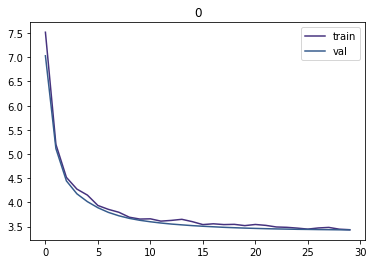

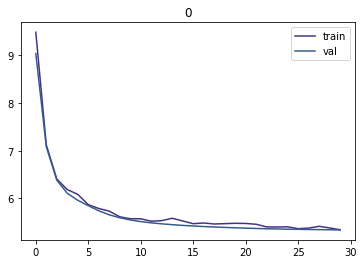

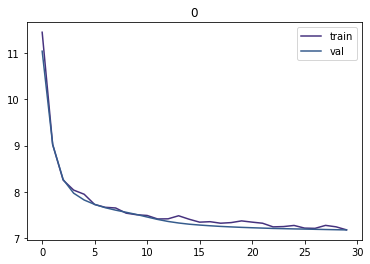

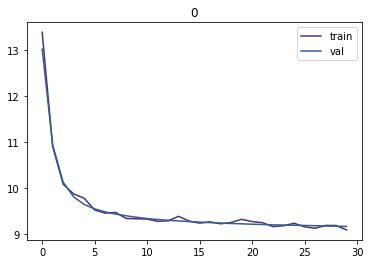

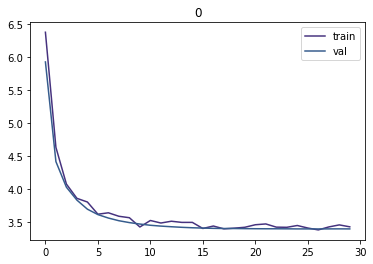

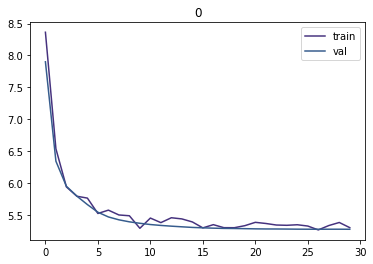

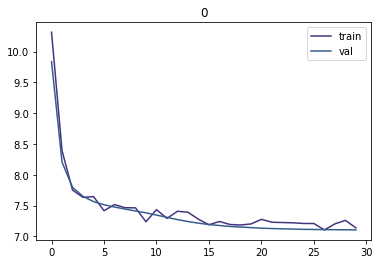

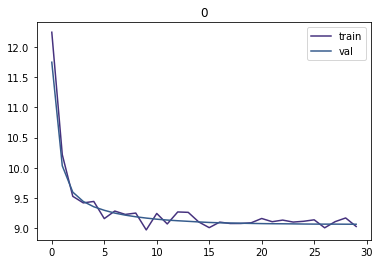

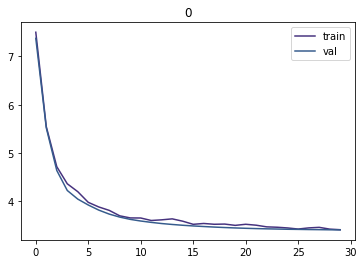

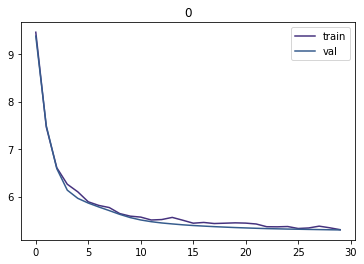

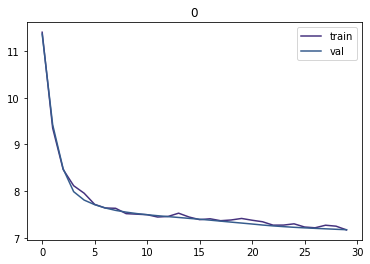

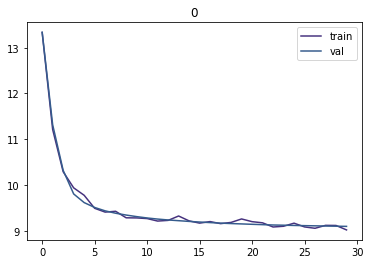

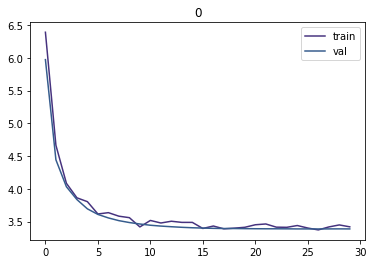

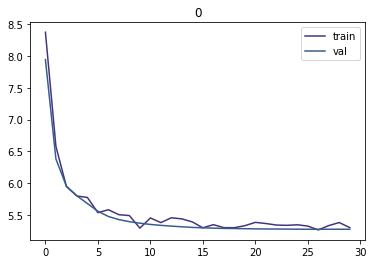

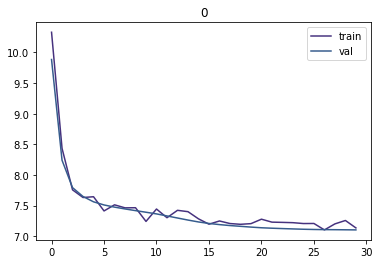

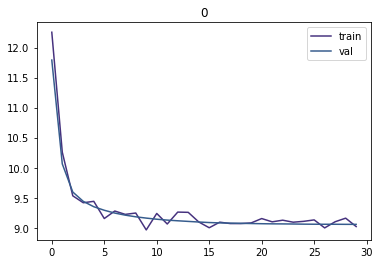

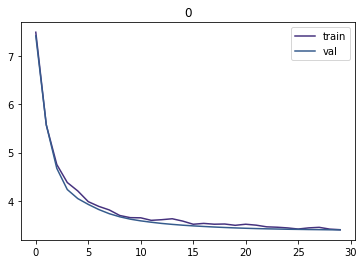

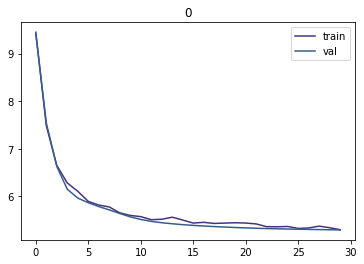

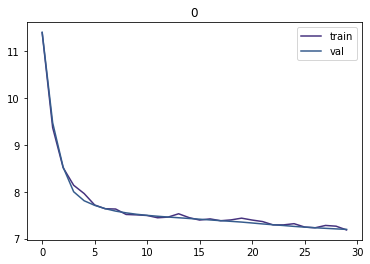

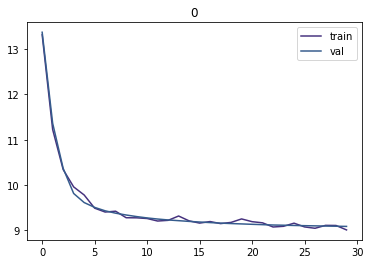

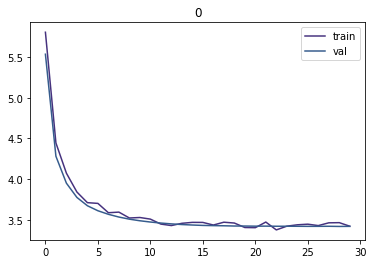

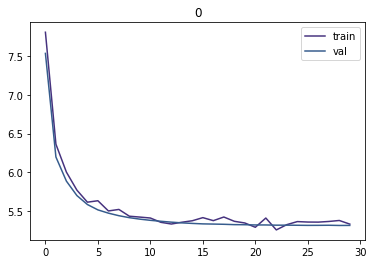

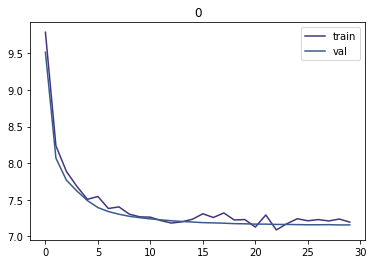

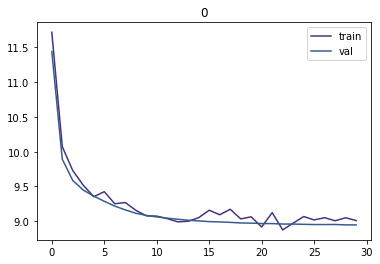

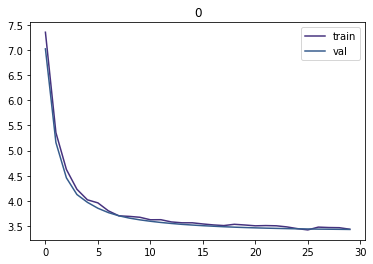

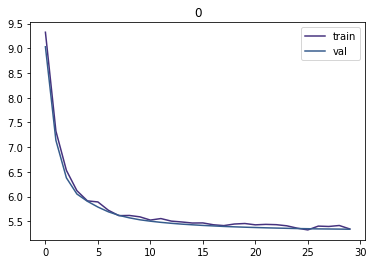

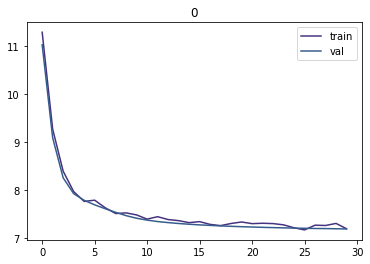

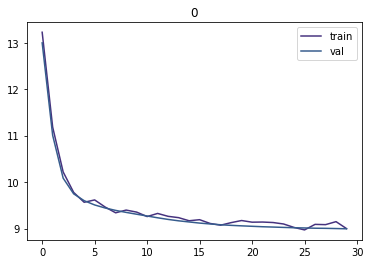

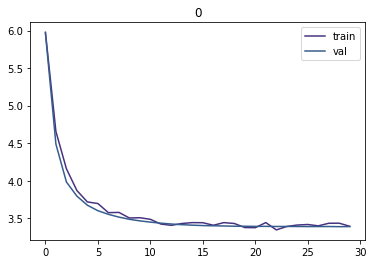

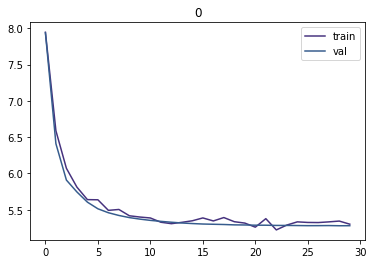

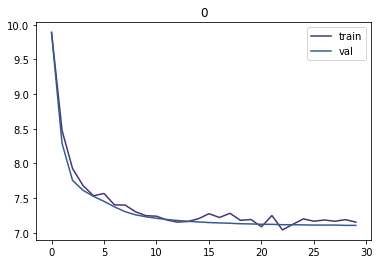

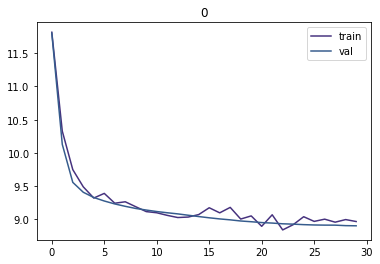

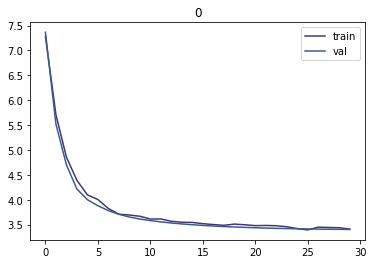

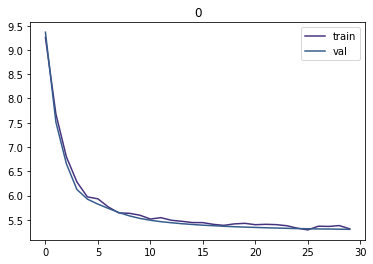

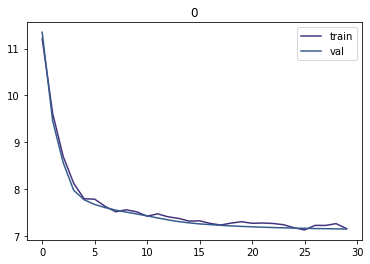

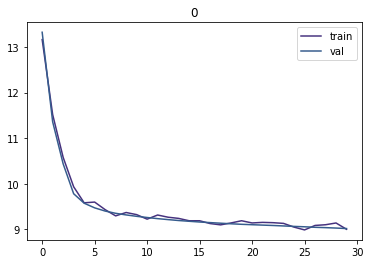

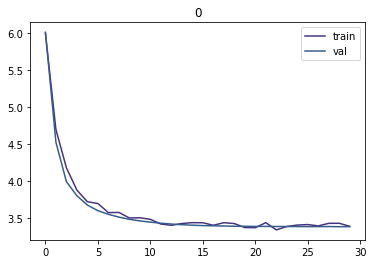

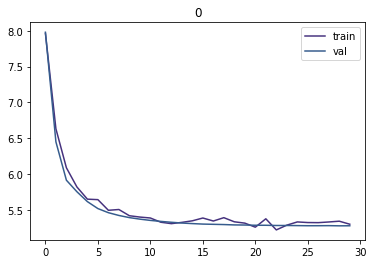

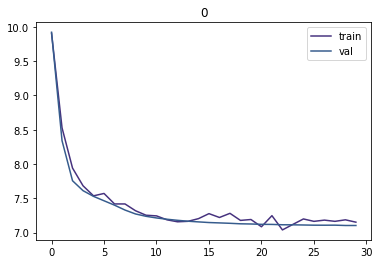

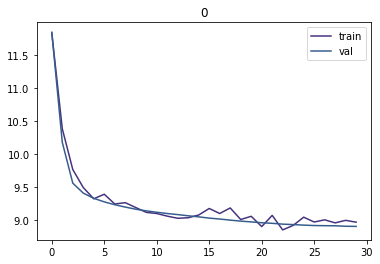

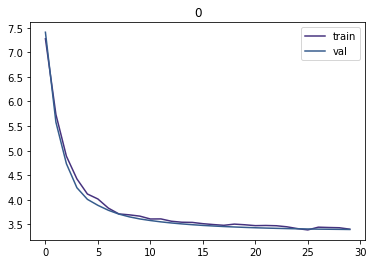

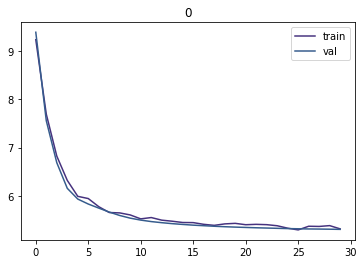

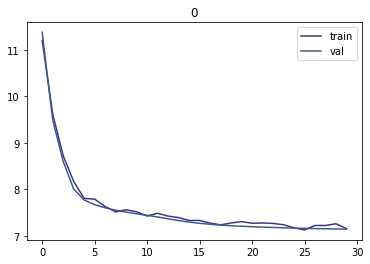

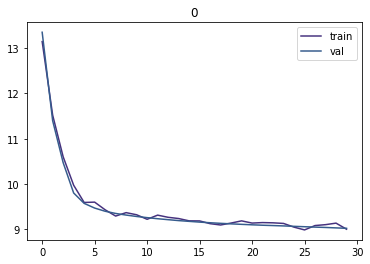

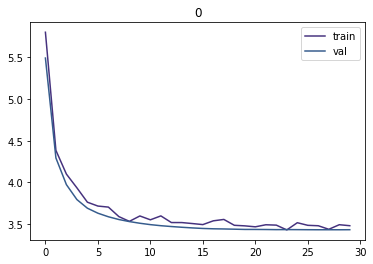

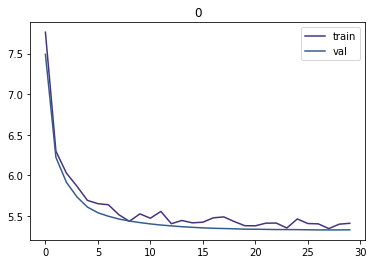

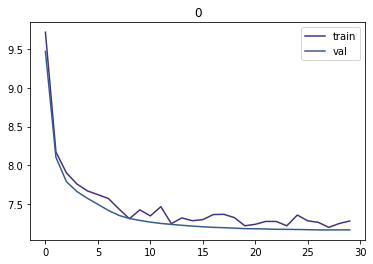

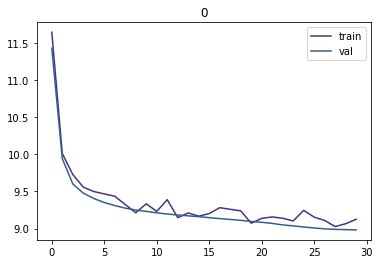

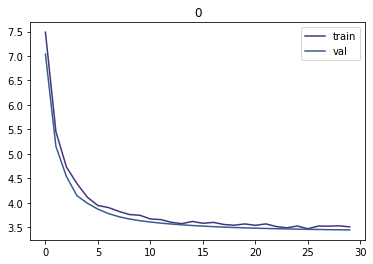

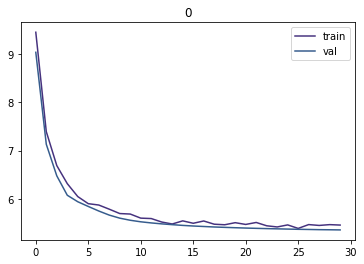

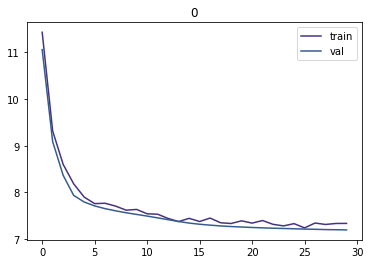

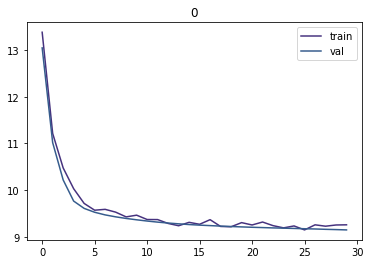

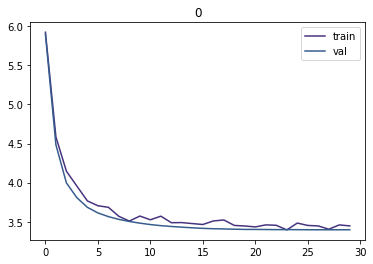

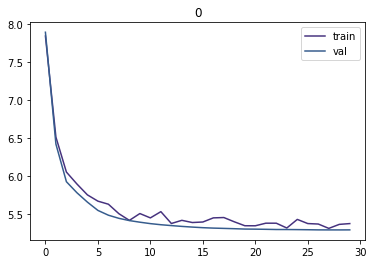

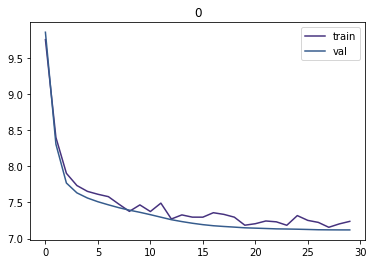

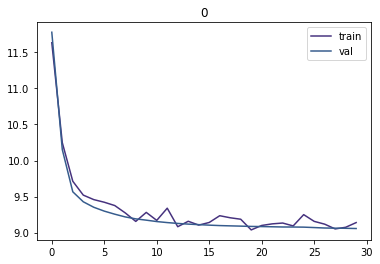

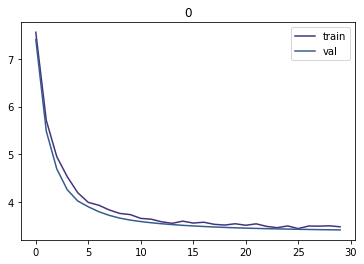

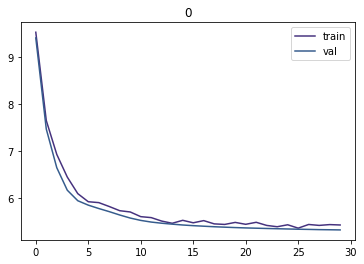

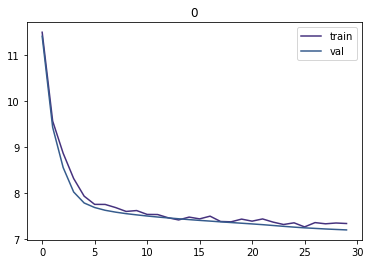

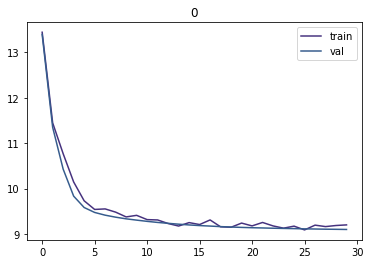

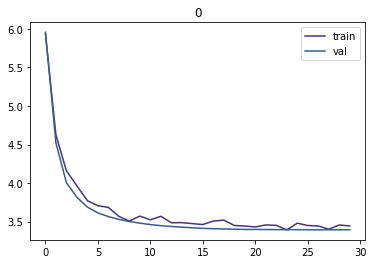

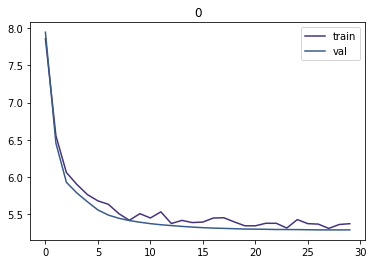

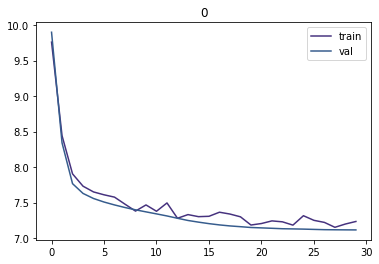

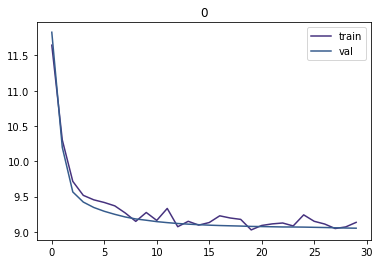

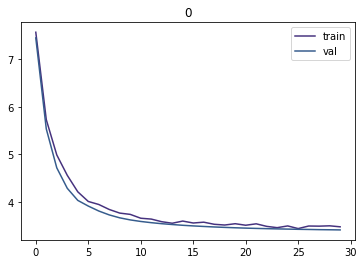

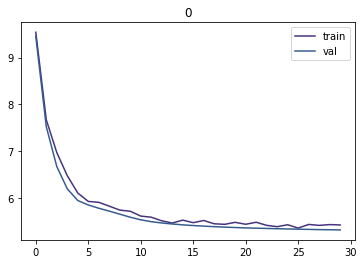

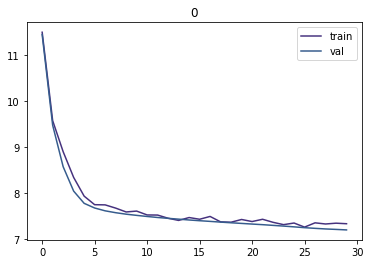

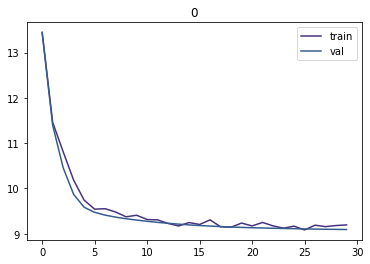

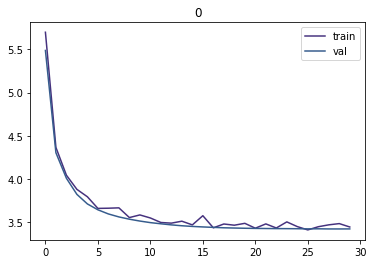

In [150]:
for idx, row in data.iterrows():
    plt.plot(row['train_loss'], label='train')
    plt.plot(row['val_loss'], label='val')
    plt.title(idx)
    plt.legend()
    plt.show();

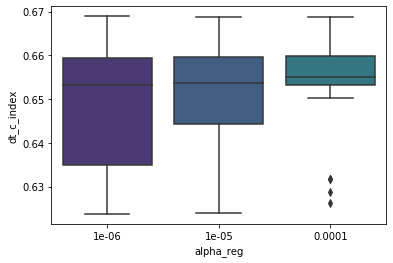

In [172]:
sns.boxplot(data=data, x='alpha_reg', y='dt_c_index');

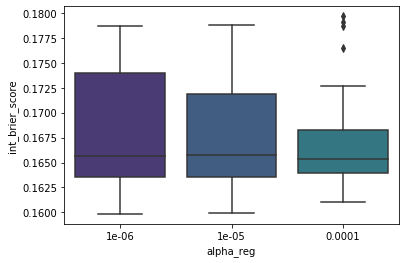

In [173]:
sns.boxplot(data=data, x='alpha_reg', y='int_brier_score');

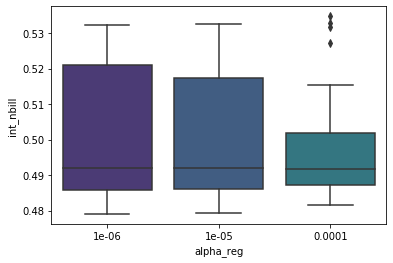

In [175]:
sns.boxplot(data=data, x='alpha_reg', y='int_nbill');

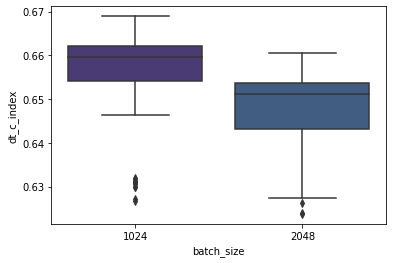

In [176]:
sns.boxplot(data=data, x='batch_size', y='dt_c_index');

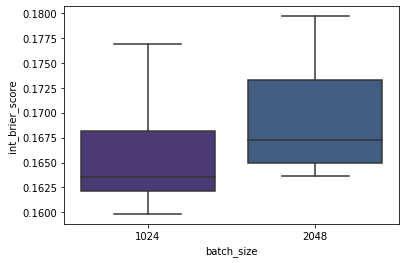

In [177]:
sns.boxplot(data=data, x='batch_size', y='int_brier_score');

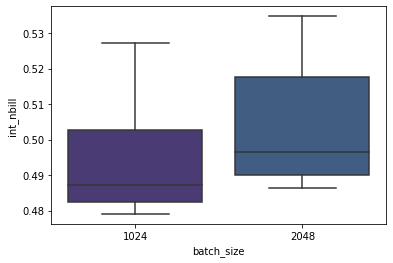

In [178]:
sns.boxplot(data=data, x='batch_size', y='int_nbill');

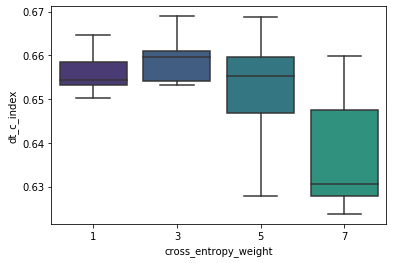

In [179]:
sns.boxplot(data=data, x='cross_entropy_weight', y='dt_c_index');

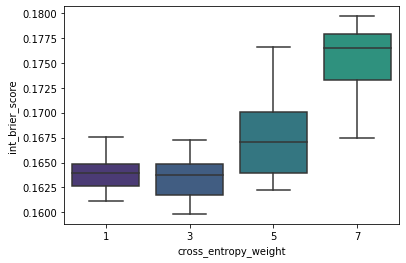

In [180]:
sns.boxplot(data=data, x='cross_entropy_weight', y='int_brier_score');

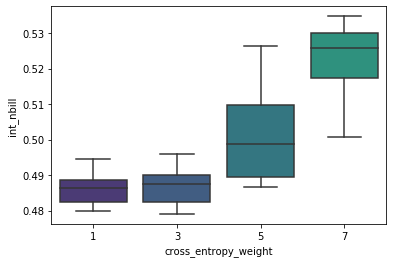

In [181]:
sns.boxplot(data=data, x='cross_entropy_weight', y='int_nbill');

In [182]:
melted_data = pd.melt(data, id_vars=['batch_size','alpha_reg', 'cross_entropy_weight','fold'], value_vars=['dt_c_index','int_brier_score','int_nbill'])

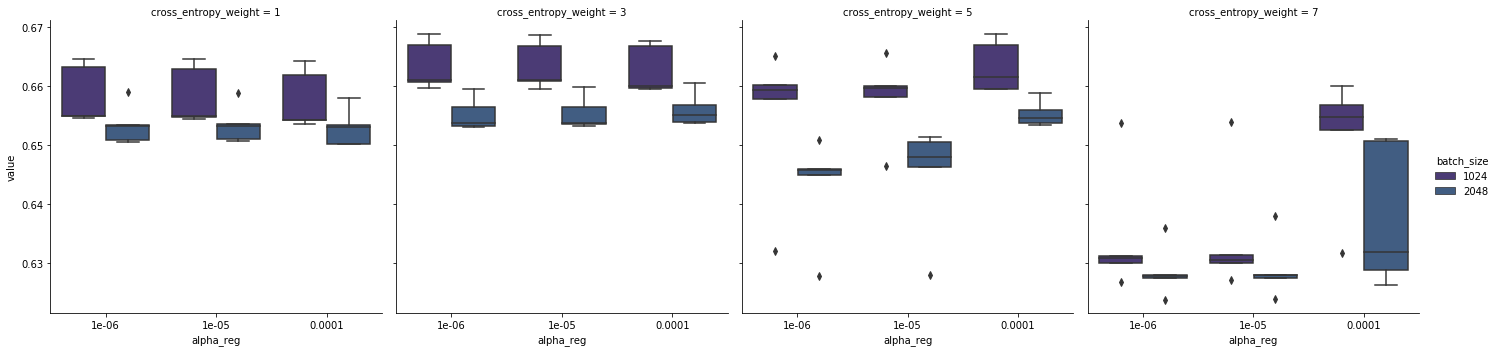

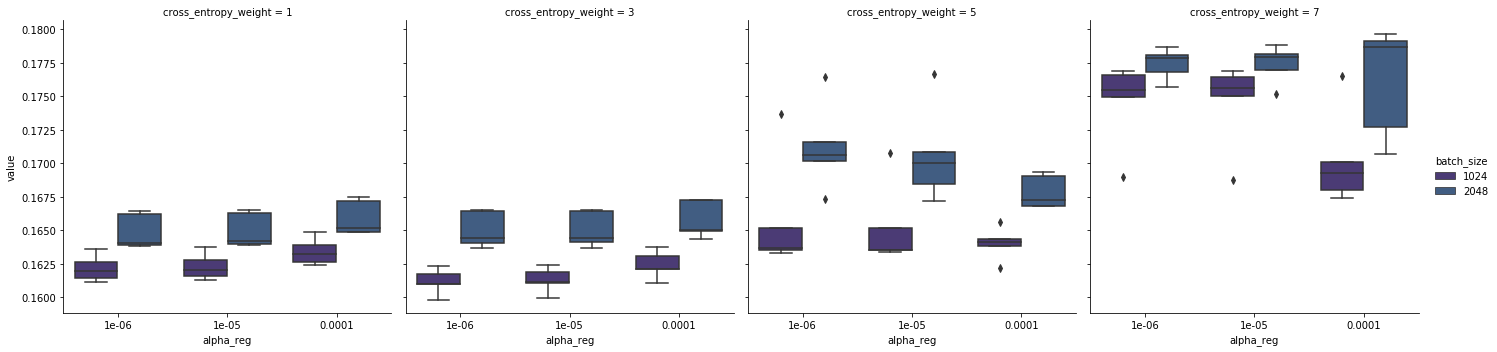

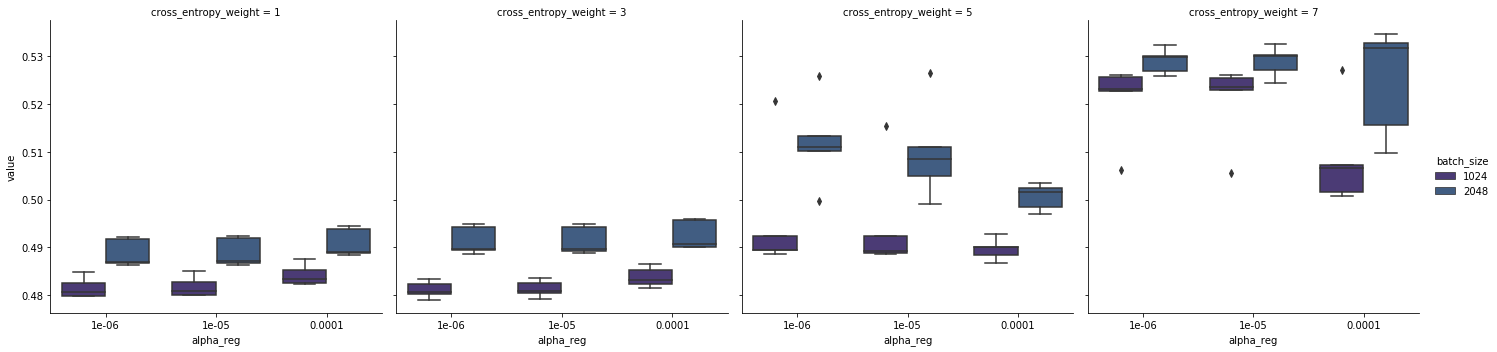

In [185]:
for m in ['dt_c_index','int_brier_score','int_nbill']:
    d = melted_data[melted_data['variable'] == m]
    sns.catplot(data=d, kind='box', x='alpha_reg', y='value', hue='batch_size', col='cross_entropy_weight')

In [186]:
best_params = data.groupby(['alpha_reg','batch_size', 'cross_entropy_weight'])[['dt_c_index', 'int_brier_score', 'int_nbill', 
                                                                                'mean_3_train_loss', 'mean_5_train_loss',
                                                                                'mean_3_val_loss', 'mean_5_val_loss']].mean()

In [187]:
best_params['dt_c_index_rank'] = best_params['dt_c_index'].rank(ascending=False)
best_params['int_brier_score_rank'] = best_params['int_brier_score'].rank()
best_params['int_nbill_rank'] = best_params['int_nbill'].rank()

In [188]:
best_params.sort_values('dt_c_index', ascending=False)

dt_c_index  int_brier_score  \
alpha_reg batch_size cross_entropy_weight                                
0.000001  1024       3                       0.663437         0.161182   
0.000010  1024       3                       0.663393         0.161282   
0.000100  1024       5                       0.663297         0.164032   
                     3                       0.662705         0.162427   
0.000001  1024       1                       0.658450         0.162174   
0.000010  1024       1                       0.658334         0.162285   
                     5                       0.657994         0.165285   
0.000100  1024       1                       0.657622         0.163408   
          2048       3                       0.655999         0.165783   
0.000010  2048       3                       0.655411         0.165059   
0.000100  2048       5                       0.655311         0.167877   
0.000001  2048       3                       0.655187         0.165036   
          1024       5                       0.654867         0.165890   
0.000010  2048       1                       0.653411         0.164971   
0.000001  2048       1                       0.653403         0.164894   
0.000100  2048       1                       0.652959         0.165937   
          1024       7                       0.651148         0.170264   
0.000010  2048       5                       0.644825         0.170637   
0.000001  2048       5                       0.643054         0.171234   
0.000100  2048       7                       0.637711         0.176179   
0.000010  1024       7                       0.634596         0.174556   
0.000001  1024       7                       0.634516         0.174579   
0.000010  2048       7                       0.629017         0.177417   
0.000001  2048       7                       0.628549         0.177442   

                                           int_nbill  mean_3_train_loss  \
alpha_reg batch_size cross_entropy_weight                                 
0.000001  1024       3                      0.481133           5.338890   
0.000010  1024       3                      0.481325           5.342482   
0.000100  1024       5                      0.489641           7.237096   
                     3                      0.483765           5.378346   
0.000001  1024       1                      0.481550           3.428484   
0.000010  1024       1                      0.481786           3.431585   
                     5                      0.494901           7.221555   
0.000100  1024       1                      0.484254           3.462375   
          2048       3                      0.492550           5.403833   
0.000010  2048       3                      0.491344           5.373142   
0.000100  2048       5                      0.500656           7.276490   
0.000001  2048       3                      0.491395           5.370778   
          1024       5                      0.496092           7.226302   
0.000010  2048       1                      0.488943           3.453739   
0.000001  2048       1                      0.488797           3.451119   
0.000100  2048       1                      0.490954           3.481943   
          1024       7                      0.508698           9.094937   
0.000010  2048       5                      0.510006           7.286148   
0.000001  2048       5                      0.512077           7.289990   
0.000100  2048       7                      0.524931           9.155502   
0.000010  1024       7                      0.520762           9.083439   
0.000001  1024       7                      0.520813           9.075961   
0.000010  2048       7                      0.528950           9.120388   
0.000001  2048       7                      0.529020           9.113146   

                                           mean_5_train_loss  mean_3_val_loss  \
alpha_reg batch_size cross_entropy_weight                                       
0.000

In [192]:
best = data[(data['batch_size'] == 1024) & (data['alpha_reg'] == 0.000001) & (data['cross_entropy_weight'] == 3)]
best

,harell_c_index,dt_c_index,int_brier_score,int_nbill,batch_size,alpha_reg,cross_entropy_weight,fold,train_loss,val_loss,learning_rate,mean_3_train_loss,mean_5_train_loss,mean_3_val_loss,mean_5_val_loss
0,0.659602,0.668899,0.159831,0.479074,1024,0.000001,3,0,"[7.9671993, 6.760627, 6.004146, 5.876092, 5.75...","[7.9416647, 6.527197, 5.9723516, 5.7971706, 5....","[0.0004, 0.000523077, 0.0006461538, 0.00076923...",5.344456,5.320994,5.263860,5.264019
0,0.653203,0.660761,0.161029,0.480260,1024,0.000001,3,1,"[8.374315, 6.5798244, 5.9486127, 5.799998, 5.7...","[7.943854, 6.3817787, 5.953568, 5.802224, 5.68...","[0.0004, 0.000523077, 0.0006461538, 0.00076923...",5.339498,5.322284,5.276623,5.276608
0,0.654303,0.661001,0.160975,0.480655,1024,0.000001,3,2,"[7.9626703, 6.630082, 6.0862436, 5.8186073, 5....","[7.978344, 6.4478474, 5.9125175, 5.7519226, 5....","[0.0004, 0.000523077, 0.0006461538, 0.00076923...",5.322803,5.322096,5.276970,5.277120
0,0.653283,0.659602,0.162319,0.483319,1024,0.000001,3,3,"[7.8597164, 6.552348, 6.057016, 5.8966126, 5.7...","[7.9476614, 6.452778, 5.92562, 5.7812424, 5.66...","[0.0004, 0.000523077, 0.0006461538, 0.00076923...",5.343295,5.352092,5.284236,5.284762
0,0.657362,0.666920,0.161758,0.482359,1024,0.000001,3,4,"[8.045492, 6.5556874, 6.006753, 5.8885584, 5.7...","[7.968354, 6.4231453, 5.9660006, 5.8217335, 5....","[0.0004, 0.000523077, 0.0006461538, 0.00076923...",5.344398,5.338711,5.280851,5.281905


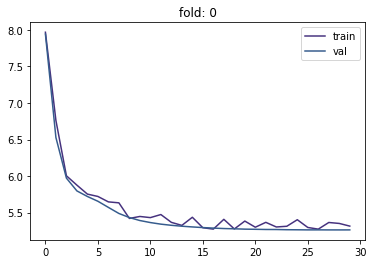

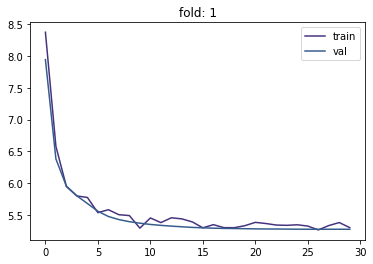

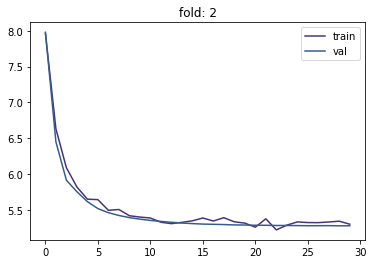

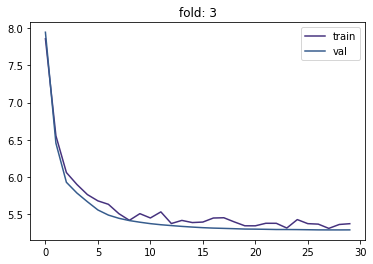

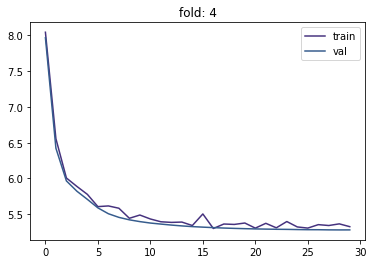

In [195]:
for idx, row in best.iterrows():
    plt.plot(row['train_loss'], label='train')
    plt.plot(row['val_loss'], label='val')
    plt.legend()
    plt.title("fold: {}".format(row['fold']))
    plt.show()

In [31]:
best_new = data[(data['batch_size'] == 1024) & (data['alpha_reg'] == 0.000001)]

In [34]:
with open('../output/hp_search_w_v2.pkl', 'rb') as f:
    data = pickle.load(f)
data = pd.concat(data)

In [35]:
best_old = data[(data['batch_size'] == 1024) & (data['alpha_reg'] == 0.000001)]

In [37]:
best_old['cross_entropy_weight'] = 0
best_all = pd.concat([best_new, best_old])

/home/islam/anaconda3/envs/pycox/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/islam/anaconda3/envs/pycox/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [40]:
melted_data = pd.melt(best_all, id_vars=['batch_size','alpha_reg', 'cross_entropy_weight','fold'], value_vars=['dt_c_index','int_brier_score','int_nbill'])

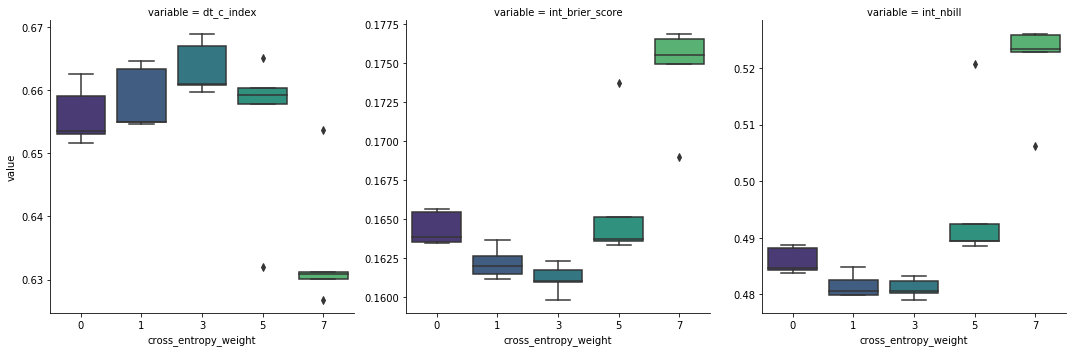

In [45]:
sns.catplot(data=melted_data, kind='box', x='cross_entropy_weight', y='value', col='variable', sharey=False);

CV evaluation of optimal model quality

In [1]:
import os
import sys
import pickle
from tqdm.notebook import tqdm as tqdm
import random

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

sys.path.append("../")

from batch_generators import BinaryDataGenerator
from models import BinaryRankingModel
from tools import test_quality
from clr import cyclic_learning_rate

In [2]:
s = 2

random.seed(s)
np.random.seed(s)
tf.set_random_seed(s)
os.environ['PYTHONHASHSEED'] = str(s)
os.environ['TF_CUDNN_DETERMINISTIC'] = str(s)

##### Load METABRIC data

In [3]:
with open('../data/metabric_cv.pkl', 'rb') as f:
    df_all = pickle.load(f)

In [4]:
df_all['cv'].keys()

dict_keys([0, 1, 2, 3, 4])

In [5]:
folds = list(df_all['cv'].keys())

Define optimal parameters

In [6]:
n_time_bins = 10
time_grid = np.linspace(0, 300, 30, dtype=np.int)
inp_shape = (None, df_all['val']['x'].shape[1])
n_epochs = 30

params = {
    'n_time_bins': n_time_bins,
    'inp_shape': inp_shape,
    'n_epochs': n_epochs,
    'seed': s,
    'max_lr': 0.002,
    'step_size': 13,
    'time_grid': time_grid,
    'alpha_reg': 1e-6,
    'batch_size': 1024,
    'cross_entropy_weight': 3,
    'model_path':'../model/opt_weibull_ce_model_'
}

Define testing function

In [7]:
def test_hp(train_data, test_data, model_params):
        
    model = BinaryRankingModel(model_params['inp_shape'], seed=model_params['seed'], alpha_reg=model_params['alpha_reg'], 
                           cross_entropy_weight=model_params['cross_entropy_weight'])
    
    # cycling learning rate
    all_lr = []
    global_step = tf.Variable(0, trainable=False)
    increment_global_step = tf.assign(global_step, global_step + 1)
    learning_rate = cyclic_learning_rate(global_step=global_step, learning_rate=model_params['max_lr'] / 5, max_lr=model_params['max_lr'], 
                                         step_size=model_params['step_size'], mode='triangular2')
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    
    train = optimizer.minimize(model.loss, global_step=global_step)
    
    # validation data
    dg = BinaryDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], batch_size=model_params['batch_size'], n_time_bins=model_params['n_time_bins'])
    val_size = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1])
    dg = BinaryDataGenerator(x=test_data['x'], y=test_data['y'], t=test_data['t'], batch_size=val_size, n_time_bins=model_params['n_time_bins'])
    [x_batch_left_val, x_batch_right_val], y_batch_val, sample_weight_val, target_val = next(dg.get_batch())
    val_size = x_batch_left_val.shape[0]
    # training data
    dg = BinaryDataGenerator(x=train_data['x'], y=train_data['y'], t=train_data['t'], batch_size=model_params['batch_size'],
                             n_time_bins=model_params['n_time_bins'])    
    n_batches = min(dg.ij_pos_sorted.shape[1], dg.ij_neg_sorted.shape[1]) // model_params['batch_size']
    
    saver = tf.train.Saver()    
    all_lr = []
    all_pred = []
    train_loss = []
    val_loss = []
    # Launch the graph
    with tf.device('/GPU:0'):
        with tf.Session() as sess:
            tf.set_random_seed(model_params['seed'])
            init = tf.initialize_all_variables()
            sess.run(init)
            # for each epoch
            for i in tqdm(range(model_params['n_epochs'])):
                # initialize generator
                gen = dg.get_batch()
                # for each batch
                for j in range(n_batches):
                    # get batch data
                    [x_batch_left, x_batch_right], y_batch, sample_weight, target = next(gen)
                    feed_dict = {
                        model.x_a: x_batch_left, 
                        model.x_b: x_batch_right, 
                        model.t_a: y_batch[:, 0].reshape((model_params['batch_size'], 1)),
                        model.t_b: y_batch[:, 1].reshape((model_params['batch_size'], 1)),
                        model.y_a: y_batch[:, 2].reshape((model_params['batch_size'], 1)),
                        model.y_b: y_batch[:, 3].reshape((model_params['batch_size'], 1)),
                        model.target: target.reshape((model_params['batch_size'], 1)),
                        model.sample_weight: sample_weight
                    }                   
                    # train model
                    _, l = sess.run([train, model.loss], feed_dict=feed_dict)
                    
                 # change learning rate
                assign_op = global_step.assign(i)
                sess.run(assign_op)               
                new_lr = sess.run(optimizer._learning_rate_tensor)
                all_lr.append(new_lr)
                # save model
                saver.save(sess, model_params['model_path'] + str(model_params['fold']))               
                # get predictions for validation data
                pred = sess.run(model.o1, feed_dict={model.x_a: test_data['x']})
                all_pred.append(pred)
                # save train loss
                train_loss.append(l)
                # save test loss
                l = sess.run(model.loss, feed_dict={
                        model.x_a: x_batch_left_val, 
                        model.x_b: x_batch_right_val, 
                        model.t_a: y_batch_val[:, 0].reshape((val_size, 1)),
                        model.t_b: y_batch_val[:, 1].reshape((val_size, 1)),
                        model.y_a: y_batch_val[:, 2].reshape((val_size, 1)),
                        model.y_b: y_batch_val[:, 3].reshape((val_size, 1)),
                        model.target: target_val.reshape((val_size, 1)),
                        model.sample_weight: sample_weight_val
                    }) 
                val_loss.append(l)
                
    return pred, train_loss, val_loss, all_lr


Evaluation of test

In [8]:
all_res_quality = []
for fold in tqdm(folds):
    train_data = df_all['cv'][fold]['train']
    test_data = df_all['cv'][fold]['test']
    tf.reset_default_graph()
    params.update({'fold': fold})
    pred, train_loss, val_loss, all_lr = test_hp(train_data=train_data, test_data=test_data, model_params=params)
    q = test_quality(t_true=test_data['t'], y_true=test_data['y'], pred=pred, time_grid=params['time_grid'], concordance_at_t=103)
    q['batch_size'] = params['batch_size']
    q['alpha_reg'] = params['alpha_reg']
    q['cross_entropy_weight'] = params['cross_entropy_weight']
    q['fold'] = fold
    q['train_loss'] = [train_loss]
    q['val_loss'] = [val_loss]
    q['learning_rate'] = [all_lr]
    all_res_quality.append(q)

    with open('../output/optimal_w_ce_3.pkl', 'wb') as f:
        pickle.dump(all_res_quality, f)





Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.dense instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [67]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("viridis")

In [68]:
with open('../output/optimal_w_ce_2.pkl', 'rb') as f:
    data = pickle.load(f)

In [69]:
data = pd.concat(data)

In [70]:
data

,harell_c_index,dt_c_index,int_brier_score,int_nbill,batch_size,alpha_reg,cross_entropy_weight,fold,train_loss,val_loss,learning_rate
0,0.646452,0.640497,0.180350,0.532283,1024,0.000001,3,0,"[7.839838, 6.6488867, 6.1711445, 5.9026966, 5....","[8.591049, 6.8600063, 6.1199694, 5.8845134, 5....","[0.0004, 0.000523077, 0.0006461538, 0.00076923..."
0,0.628420,0.638119,0.173266,0.511275,1024,0.000001,3,1,"[7.9862022, 6.4201365, 6.0179005, 5.831727, 5....","[7.9549637, 6.6052217, 6.030059, 5.8576584, 5....","[0.0004, 0.000523077, 0.0006461538, 0.00076923..."
0,0.626728,0.596161,0.179542,0.524298,1024,0.000001,3,2,"[8.049967, 6.510586, 5.8479586, 5.8267517, 5.7...","[7.7369423, 6.363596, 6.021805, 5.9000583, 5.8...","[0.0004, 0.000523077, 0.0006461538, 0.00076923..."
0,0.645888,0.660383,0.172736,0.512917,1024,0.000001,3,3,"[8.079762, 6.599616, 5.8787594, 5.8253255, 5.7...","[7.757923, 6.366982, 5.884882, 5.7363534, 5.63...","[0.0004, 0.000523077, 0.0006461538, 0.00076923..."
0,0.657220,0.622307,0.175347,0.517606,1024,0.000001,3,4,"[8.0161, 6.5746536, 6.029455, 5.761718, 5.7027...","[8.3982315, 6.765424, 6.2208633, 5.985136, 5.8...","[0.0004, 0.000523077, 0.0006461538, 0.00076923..."


In [49]:
data['mean_3_train_loss'] = data['train_loss'].apply(lambda x: np.mean(np.array(x[-3:])))
data['mean_5_train_loss'] = data['train_loss'].apply(lambda x: np.mean(np.array(x[-5:])))
data['mean_3_val_loss'] = data['val_loss'].apply(lambda x: np.mean(np.array(x[-3:])))
data['mean_5_val_loss'] = data['val_loss'].apply(lambda x: np.mean(np.array(x[-5:])))

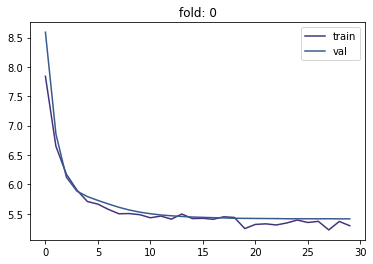

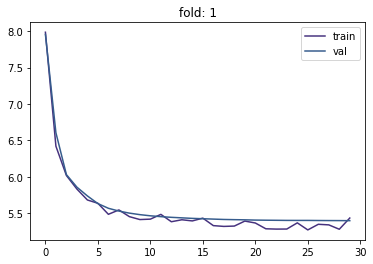

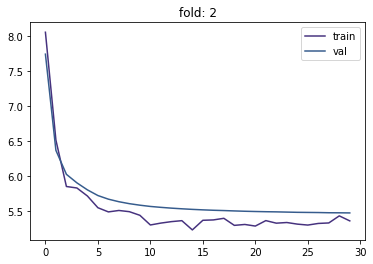

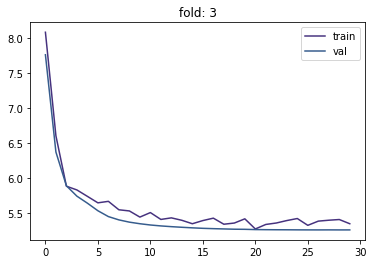

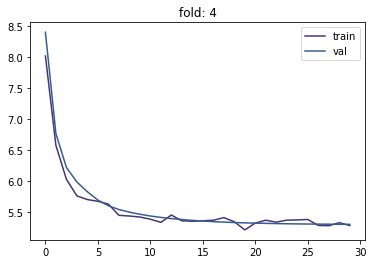

In [50]:
for idx, row in data.iterrows():
    plt.plot(row['train_loss'], label='train')
    plt.plot(row['val_loss'], label='val')
    plt.title("fold: {}".format(row['fold']))
    plt.legend()
    plt.show();

In [51]:
melted_data = pd.melt(data, id_vars=['batch_size','alpha_reg', 'cross_entropy_weight','fold'], value_vars=['dt_c_index','int_brier_score','int_nbill'])

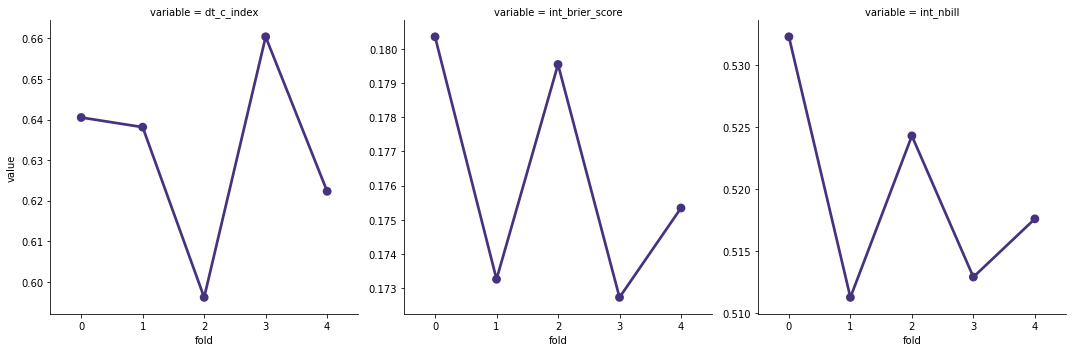

In [52]:
sns.catplot(data=melted_data, x='fold', kind='point', y='value', col='variable', sharey=False);

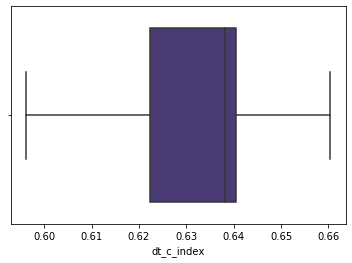

In [53]:
sns.boxplot(data['dt_c_index'])

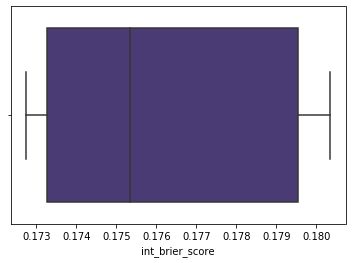

In [54]:
sns.boxplot(data['int_brier_score'])

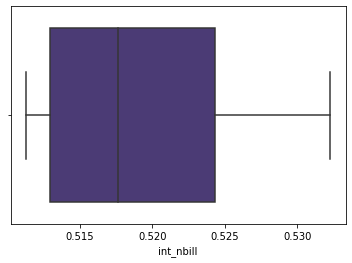

In [55]:
sns.boxplot(data['int_nbill'])

In [56]:
mean_quality = data.groupby(['alpha_reg','batch_size', 'cross_entropy_weight'])[['dt_c_index', 'int_brier_score', 'int_nbill', 
                                                                                'mean_3_train_loss', 'mean_5_train_loss',
                                                                                'mean_3_val_loss', 'mean_5_val_loss']].mean()

In [57]:
mean_quality.sort_values('dt_c_index', ascending=False)

,,,dt_c_index,int_brier_score,int_nbill,mean_3_train_loss,mean_5_train_loss,mean_3_val_loss,mean_5_val_loss
alpha_reg,batch_size,cross_entropy_weight,,,,,,,
0.000001,1024,3,0.631494,0.176248,0.519676,5.339144,5.336414,5.368435,5.369282


In [58]:
data_ce = data

In [59]:
with open('../output/optimal_w_2.pkl', 'rb') as f:
    data = pickle.load(f)
data = pd.concat(data)

In [61]:
data['cross_entropy_weight'] = 0

In [63]:
all_data = pd.concat([data_ce, data])

/home/islam/anaconda3/envs/pycox/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [65]:
melted_data = pd.melt(all_data, id_vars=['batch_size','alpha_reg', 'cross_entropy_weight','fold'], value_vars=['dt_c_index','int_brier_score','int_nbill'])

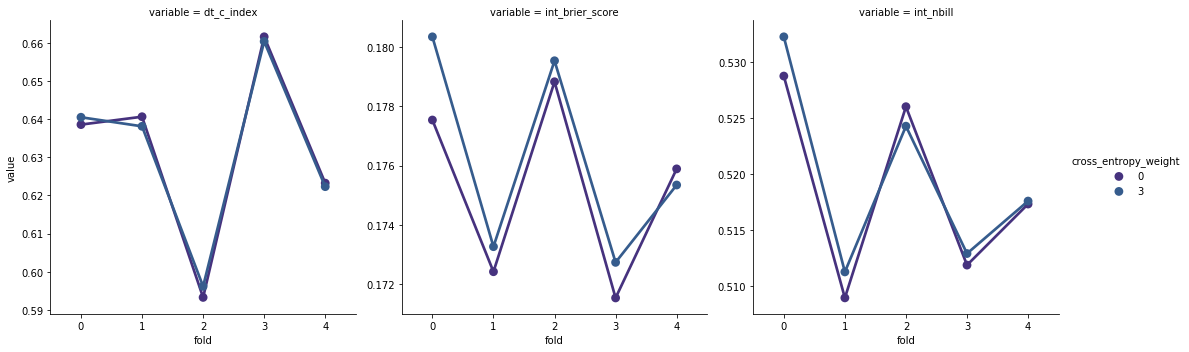

In [66]:
sns.catplot(data=melted_data, x='fold', kind='point', y='value', col='variable', hue='cross_entropy_weight', sharey=False);